# Table of Contents

- [1. Introduction](#1.-Introduction)
    - [1.1. Check environment](#1.1.-Check-environment)
- [2. Data Preloading](#2.-Data-Preloading)
    - [2.1. Load downloaded data using customised function](#2.1.-Load-downloaded-data-using-customised-function)
    - [2.2. Stratified Data Split (50k:10k:10k)](#2.2.-Stratified-Data-Split-(50k:10k:10k)-)
    - [2.3. Sanity check](#2.3.-Sanity-check)
    - [2.4. Preload Dataset using Custom Dataset](#2.4.-Preload-Dataset-using-Custom-Dataset)
- [3. Define training loops](#3.-Define-training-loops)
    - [3.1. Define Single Train Loop](#3.1.-Define-Single-Train-Loop)
    - [3.2. Define Single Validation Loop](#3.2.-Define-Single-Validation-Loop)
    - [3.3. Define epoch iteration loop](#3.3.-Define-epoch-iteration-loop)
- [4. Baseline Fully Connected Neural Network](#4.-Baseline-Fully-Connected-Neural-Network)
    - [4.1. Neural network structure and parameters](#4.1.-Neural-network-structure-and-parameters)
    - [4.2. Loading & Training](#4.2.-Loading-&-Training)
    - [4.3. Model performance over epochs](#4.3.-Model-performance-over-epochs)
    - [4.4. Model Testing](#4.4.-Model-Testing)
    - [4.5 Leaky ReLU & Adam](#4.5-Leaky-ReLU-&-Adam)
- [5. Things that did not work out](#5.-Things-that-did-not-work-out)
    - [5.1. GPU/MPS training](#5.1.-GPU/MPS-training)
    - [5.2. Softmax & Vanishing gradients](#5.2.-Softmax-&-Vanishing-gradients)
- [References](#References)

# 1. Introduction

This notebook is part of Hao Chen's deep learning project for LPI Artificial intelligence (2023-2023). This project builds a fully connected neural network and a convolutional neural network for FashionMNIST dataset. 

This notebook contains the code for the fully connected neural network (MLP). The structure of MLP is show below:
- 1 input layer (784 input, 512 output, ReLU activation)
- 1 hidden layer (512 input, 512 output, ReLU activation)
- 1 output layer (512 input, 10 output, no activation function)
- Total: 669706 parameters.

Overall, I achieved ~0.88 accuracy on the test dataset, after 50 training epochs, despite overfitting.

## 1.1. Check environment

In [1]:
import torch
from platform import python_version

# Report the versions of overall environment 
print(f'Python version: {python_version()}')
print(f'PyTorch version: {torch.__version__}')

# Report the availability or GPU and MPS training 
cuda_available = torch.cuda.is_available()
mps_available = torch.backends.mps.is_available()

print(f'Cuda Availablility: {cuda_available}')
print(f'Metal Performance Shaders (MPS) Availablility: {mps_available}')

Python version: 3.11.5
PyTorch version: 2.1.2
Cuda Availablility: False
Metal Performance Shaders (MPS) Availablility: True


# 2. Data Preloading

## 2.1. Load downloaded data using customised function

In [2]:
import numpy as np
from utils.dataset import import_data

# Set data path
train_label_path = './data/FashionMNIST/raw/train-labels-idx1-ubyte'
train_images_path = './data/FashionMNIST/raw/train-images-idx3-ubyte'
test_label_path = './data/FashionMNIST/raw/t10k-labels-idx1-ubyte'
test_images_path = './data/FashionMNIST/raw/t10k-images-idx3-ubyte'

# import data
images = import_data(train_images_path, images=True, train=True)
labels = import_data(train_label_path, images=False, train=True)
test_images = import_data(test_images_path, images=True, train=False)
test_labels = import_data(test_label_path, images=False, train=False)

Imported file: ./data/FashionMNIST/raw/train-images-idx3-ubyte
Data type: images; Data shape: (60000, 784)
Imported file: ./data/FashionMNIST/raw/train-labels-idx1-ubyte
Data type: labels; Data shape: (60000,)
Imported file: ./data/FashionMNIST/raw/t10k-images-idx3-ubyte
Data type: images; Data shape: (10000, 784)
Imported file: ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte
Data type: labels; Data shape: (10000,)


## 2.2. Stratified Data Split (50k:10k:10k)

The original data has 60k samples in training dataset and 10k samples in test dataset. The split was stratified based on the class of target labels. 

Here I split the original training dataset into 50k samples for training and 10k samples for validation, stratified based on the class of target labels. 

In [3]:
from sklearn.model_selection import train_test_split

train_images, val_images, train_labels, val_labels = train_test_split(
    images, labels, test_size=1/6, random_state=42, stratify=labels
)

In [4]:
print(f'The shape of train image data: {train_images.shape}')
print(f'The shape of train label data: {train_labels.shape}')
print(f'The shape of validation image data: {val_images.shape}')
print(f'The shape of validation label data: {val_labels.shape}')
print(f'The shape of validation image data: {test_images.shape}')
print(f'The shape of test label data: {test_labels.shape}')

The shape of train image data: (50000, 784)
The shape of train label data: (50000,)
The shape of validation image data: (10000, 784)
The shape of validation label data: (10000,)
The shape of validation image data: (10000, 784)
The shape of test label data: (10000,)


## 2.3. Sanity check

### 2.3.1. Check class distribution

Check number of classes in each dataset

In [5]:
import pandas as pd

# Store the names of target labels into a list
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']

# Count the number of labels in each dataset
label_counts = {}
label_counts['train'] = pd.Series(train_labels).sort_values().value_counts()
label_counts['val'] = pd.Series(val_labels).sort_values().value_counts()
label_counts['test']  = pd.Series(test_labels).sort_values().value_counts()

# Present the distribution using pandas dataframe
label_counts_df = pd.DataFrame(label_counts)
label_counts_df.index = classes

label_counts_df

,train,val,test
T-shirt/top,5000,1000,1000
Trouser,5000,1000,1000
Pullover,5000,1000,1000
Dress,5000,1000,1000
Coat,5000,1000,1000
Sandal,5000,1000,1000
Shirt,5000,1000,1000
Sneaker,5000,1000,1000
Bag,5000,1000,1000
Ankle Boot,5000,1000,1000


### 2.3.2 Check images

Randomly select one image from each class, display them.

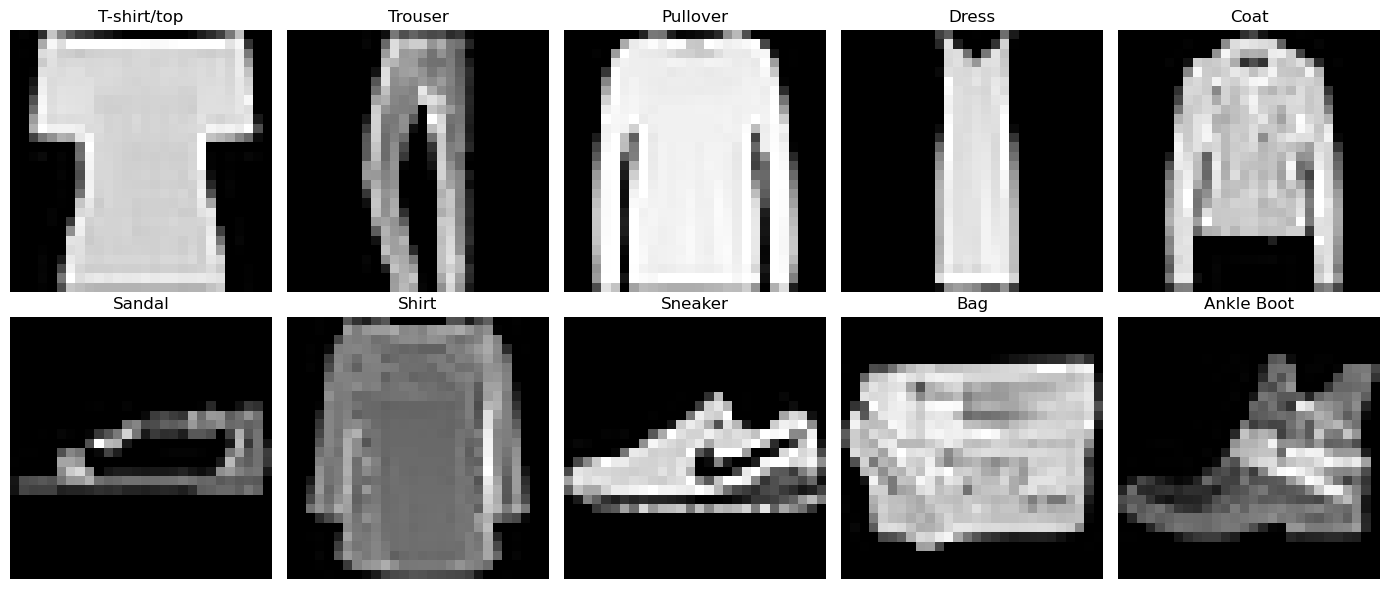

In [6]:
import matplotlib.pyplot as plt

classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']

# Set up a figure with 10 axes
fig, axes = plt.subplots(2, 5, figsize=(14, 6))

for i in range(len(classes)):
    # Find indices of all images belonging to class i
    class_indices = np.where(train_labels == i)[0]
    # Randomly sample one index
    image_idx = np.random.choice(class_indices)
    # Retrieve and display the randomly selected image
    # Reshape the flattened image data back to 28*28 pixels
    image_data = train_images[image_idx].reshape(28, 28)
    # Set cmaps as 'gray', as picture is in grayscale
    axes[i // 5, i % 5].imshow(image_data, cmap='gray')
    axes[i // 5, i % 5].axis('off')
    axes[i // 5, i % 5].set_title(classes[i])

# Adjust spacing and display the plot
plt.tight_layout()
plt.show()

## 2.4. Preload Dataset using Custom Dataset

In [7]:
from utils.dataset import FashionData

In [8]:
train_data = FashionData(train_images, train_labels)
val_data = FashionData(val_images, val_labels)
test_data = FashionData(test_images, test_labels)

# 3. Define training loops

### 3.1. Define Single Train Loop

In [9]:
def train(dataloader, model, optimizer, loss_fn, metric, device):
    train_loss = 0.0

    # Set the model to train mode
    model.train()
    # Clear the internal state of the metric
    metric.reset()

    for images, labels in dataloader:
        
        # Send data to device
        X, y = images.to(device), labels.to(device)

        # Zero gradients for each batch
        optimizer.zero_grad()

        # Compute loss
        outputs = model(X)
        loss = loss_fn(outputs, y)

        # Backpropagation 
        loss.backward()
        optimizer.step()
        
        # Store loss
        train_loss += loss.item()
        
        # Update the the metric with prediction of the batch
        _, preds = torch.max(outputs, 1)
        metric.update(preds, y)

    # Calculate average training loss during one epoch
    avg_train_loss = train_loss / len(dataloader)
    print(f'average training loss: {avg_train_loss}')

    # Calculate the metric over the whole epoch
    train_metric = metric.compute().item()
    print(f'train set score: {train_metric}')

    # return accuracy over the epoch
    return avg_train_loss, train_metric

### 3.2. Define Single Validation Loop

In [10]:
def test(dataloader, model, loss_fn, metric, device, validate=True):
    # Set the model to evaluation mode
    model.eval()
    # Clear internal state of metric
    metric.reset()

     # Seepd up the forward pass by disabling gradient calculation
    with torch.no_grad():
        test_loss = 0.0
        for images, labels in dataloader:
            # Send data to CPU
            X, y = images.to(device), labels.to(device)

            # Compute prediction error
            outputs = model(X)
            loss = loss_fn(outputs, y)

            # Store loss
            test_loss += loss.item()

            # Compute accuracy
            # Update the the metric with prediction of the batch
            _, preds = torch.max(outputs, 1)
            metric.update(preds, y)
        
        if validate:
            situation = 'validation'
        else:
            situation = 'test'

        # Calculate average validation loss during one epoch
        avg_test_loss = test_loss / len(dataloader)
        print(f'average {situation} loss: {avg_test_loss}')

        # Calculate accuracy over the epoch
        test_metric = metric.compute().item()
        print(f'{situation} set score: {test_metric}')

    return avg_test_loss, test_metric

### 3.3. Define epoch iteration loop

In [11]:
from collections import defaultdict
import time

In [12]:
def train_validate_iteration(
        train_dataloader, val_dataloader,
        num_epochs,
        model, optimizer, loss_fn, metric,
        device
):
    # initialise empty dictionary to store loss and metrics
    epoch_summary = defaultdict(list)
    
    print(f'Total number of epochs: {num_epochs}')
    epoch_summary['num_epochs'].append(num_epochs)
    
    # Record the start time
    start_time = time.time()

    for epoch in range(num_epochs):
        # train loop
        avg_train_loss, train_metric = train(
            dataloader = train_dataloader,
            model=model,
            optimizer=optimizer,
            loss_fn=loss_fn,
            metric=metric,
            device=device
            )
        epoch_summary['train_loss'].append(avg_train_loss)
        epoch_summary['train_score'].append(train_metric)

        # validation loop
        avg_val_loss, val_metric = test(
            dataloader = val_dataloader,
            model=model,
            loss_fn=loss_fn,
            metric=metric,
            device=device,
            validate=True
            )
        epoch_summary['val_loss'].append(avg_val_loss)
        epoch_summary['val_score'].append(val_metric)

        print(f"-------------------------------")

    # Record the end time
    end_time = time.time()

    # Calculate the elapsed time
    elapsed_time = end_time - start_time
    epoch_summary['time'].append(elapsed_time)

    print(f"Time taken: {elapsed_time:.2f} seconds")

    return epoch_summary

# 4. Baseline Fully Connected Neural Network

The code below will build a baseline fully connected neural network, with parameters and loss functions from this [pytorch tutorial](https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html).

## 4.1. Neural network structure and parameters

In [13]:
from torch import nn
import time
import torchmetrics

In [14]:
n_feature = 28 * 28 # set n_feature = n_pixel, as the image has 28x28 pixels 
n_labels = len(classes) # number of output feature, fed into Softmax

class BaselineFCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(n_feature, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, n_labels)

    def forward(self, x):
        x = self.flatten(x)  # Flatten the input data
        x = nn.functional.relu(self.fc1(x)) # Set Relu activation funciton
        x = nn.functional.relu(self.fc2(x)) # Set Relu activation funciton
        x = self.fc3(x)

        return x

### Note

nn.Relu() vs nn.functional.relu()
- nn.ReLU() creates an nn.Module which you can add e.g. to an nn.Sequential model.
nn.functional.relu on the other side is just the functional API call to the relu function, so that you can add it e.g. in your forward method yourself. From [this post](https://discuss.pytorch.org/t/whats-the-difference-between-nn-relu-vs-f-relu/27599). 

number of parameters:
- First layer: 784 * 512 + 512 = 401920
- ReLU: no parameter
- Second layer: 512 * 512 + 512 = 262656
- ReLU: no parameter
- Third layer: 512 * 10 + 10 = 5130
- Total: 669706

## 4.2. Loading & Training

In [15]:
# Loading
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_data, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False)

In [16]:
# training
device ='cpu'
metric = torchmetrics.Accuracy(task='multiclass', num_classes=10)
model = BaselineFCNN().to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=.001)
metric = torchmetrics.Accuracy(task='multiclass', num_classes=10).to(device)

summary = train_validate_iteration(
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    num_epochs=50,
    model=model,
    optimizer=optimizer,
    loss_fn=loss_fn,
    metric=metric,
    device=device
)

Total number of epochs: 50
average training loss: 0.8444333303424404
train set score: 0.7960399985313416
average validation loss: 0.48289523847923155
validation set score: 0.8342000246047974
-------------------------------
average training loss: 0.4055700862727812
train set score: 0.8543400168418884
average validation loss: 0.4077659587191928
validation set score: 0.8551999926567078
-------------------------------
average training loss: 0.35387619432357265
train set score: 0.8729000091552734
average validation loss: 0.4818304089983557
validation set score: 0.8338000178337097
-------------------------------
average training loss: 0.323302347517913
train set score: 0.883679986000061
average validation loss: 0.382396999105906
validation set score: 0.867900013923645
-------------------------------
average training loss: 0.2984326901986166
train set score: 0.8907600045204163
average validation loss: 0.3820834875486459
validation set score: 0.864300012588501
-------------------------------
a

## 4.3. Model performance over epochs

From the graph below, we can see that the model performance starts to plateau after around 10 epoches. 

Model performance also starts to fluctuate and even decrease after around 20 epoches, indicating over-fitting.

To address this, we can use early stopping, data augmentation, and other methods. I'll implement these methods in the CNN training. 

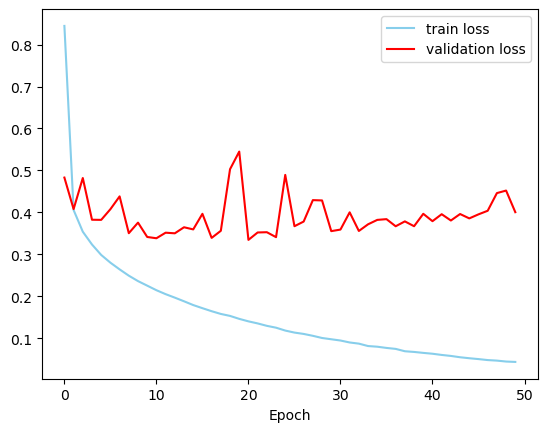

In [17]:
plt.plot(summary['train_loss'], color='skyblue', label='train loss')
plt.plot(summary['val_loss'], color='red', label='validation loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

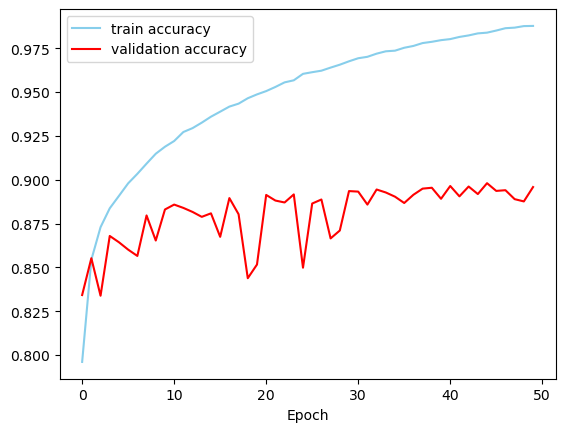

In [18]:
plt.plot(summary['train_score'], color='skyblue', label='train accuracy')
plt.plot(summary['val_score'], color='red', label='validation accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## 4.4. Model Testing

In [19]:
from utils.model_train_test import metrics_across_classes

In [20]:
metrics_across_classes(test_dataloader, model, device, classes)

         class  precision  recall  f1-score  support
0  T-shirt/top   0.807877   0.841  0.824106     1000
1      Trouser   0.989754   0.966  0.977733     1000
2     Pullover   0.801211   0.794  0.797589     1000
3        Dress   0.869059   0.896  0.882324     1000
4         Coat   0.773345   0.853  0.811222     1000
5       Sandal   0.967807   0.962  0.964895     1000
6        Shirt   0.733967   0.618  0.671010     1000
7      Sneaker   0.943676   0.955  0.949304     1000
8          Bag   0.961576   0.976  0.968735     1000
9   Ankle Boot   0.958794   0.954  0.956391     1000
--------------------------------------------------
Overall accuracy: 0.882
Macro average precision: 0.881, Recall: 0.882, F1: 0.880
Weighted average precision: 0.881, Recall: 0.882, F1: 0.880


## 4.5 Leaky ReLU & Adam

Below I want to try if using LeakyReLU & Adam optimizer can help improve the model performance. The performance of this model is similar to the previous one, but with severe overfitting.

Mechanisms:
- LeakyReLU suffers less from vanishing gradients than ReLU, as it has a small, positive gradient for negative inputs.
- Adam optimizer incoporates these two improved features, compared with SGD optimizer.
    - **Adaptive learning rate**: decrease the learning rate during training for parameters that are infrequently updated
    - **Gradient momentum**: update for each parameter based on the size of its previous gradients

In [21]:
# Define a neural network with LeakyReLU
n_feature = 28 * 28 # set n_feature = n_pixel, as the image has 28x28 pixels 
n_labels = len(classes) # number of output feature

class LeakyBaselineFCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(n_feature, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, n_labels)

    def forward(self, x):
        x = self.flatten(x)  # Flatten the input data
        x = nn.functional.leaky_relu(self.fc1(x)) # Set Relu activation funciton
        x = nn.functional.leaky_relu(self.fc2(x)) # Set Relu activation funciton
        x = self.fc3(x)

        return x

In [22]:
# training
device ='cpu'
metric = torchmetrics.Accuracy(task='multiclass', num_classes=10)
model = LeakyBaselineFCNN().to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=.001)
metric = torchmetrics.Accuracy(task='multiclass', num_classes=10).to(device)

summary = train_validate_iteration(
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    num_epochs=50,
    model=model,
    optimizer=optimizer,
    loss_fn=loss_fn,
    metric=metric,
    device=device
)

Total number of epochs: 50
average training loss: 0.8618910898790335
train set score: 0.7989799976348877
average validation loss: 0.42123340962419087
validation set score: 0.8468999862670898
-------------------------------
average training loss: 0.42345705161542846
train set score: 0.8434600234031677
average validation loss: 0.38848067820072174
validation set score: 0.8639000058174133
-------------------------------
average training loss: 0.39266961555727914
train set score: 0.8547199964523315
average validation loss: 0.4048840382676216
validation set score: 0.8521999716758728
-------------------------------
average training loss: 0.38087132045298894
train set score: 0.8618000149726868
average validation loss: 0.3593846363531556
validation set score: 0.8751000165939331
-------------------------------
average training loss: 0.3607188447395249
train set score: 0.8690400123596191
average validation loss: 0.4128311138813663
validation set score: 0.8572999835014343
-------------------------

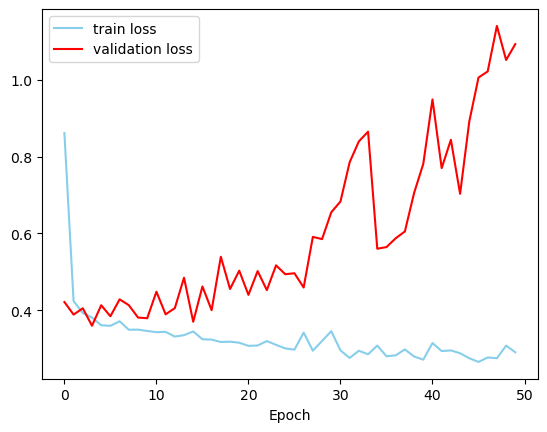

In [23]:
plt.plot(summary['train_loss'], color='skyblue', label='train loss')
plt.plot(summary['val_loss'], color='red', label='validation loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

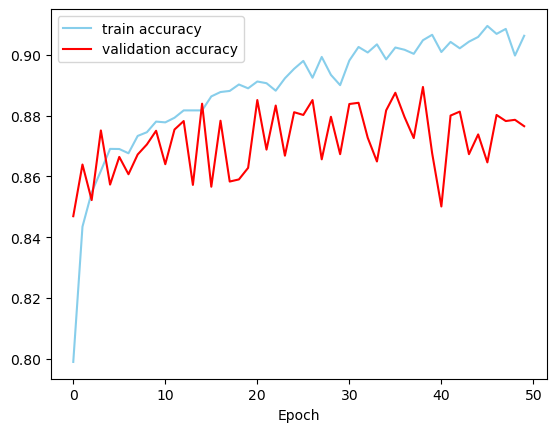

In [24]:
plt.plot(summary['train_score'], color='skyblue', label='train accuracy')
plt.plot(summary['val_score'], color='red', label='validation accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [25]:
metrics_across_classes(test_dataloader, model, device, classes)

         class  precision  recall  f1-score  support
0  T-shirt/top   0.841772   0.798  0.819302     1000
1      Trouser   0.985700   0.965  0.975240     1000
2     Pullover   0.660420   0.881  0.754927     1000
3        Dress   0.808399   0.924  0.862343     1000
4         Coat   0.855769   0.623  0.721065     1000
5       Sandal   0.973442   0.953  0.963113     1000
6        Shirt   0.711883   0.635  0.671247     1000
7      Sneaker   0.946885   0.927  0.936837     1000
8          Bag   0.978328   0.948  0.962925     1000
9   Ankle Boot   0.920877   0.966  0.942899     1000
--------------------------------------------------
Overall accuracy: 0.862
Macro average precision: 0.868, Recall: 0.862, F1: 0.861
Weighted average precision: 0.868, Recall: 0.862, F1: 0.861


# 5. Things that did not work out

## 5.1. GPU/MPS training

### Slow training

I used timeit to test the training time of the model (5 epoches) with different number of workers on my CPU as well as MPS (the cuda equivalent on macbook). However, using more workers or MPS actually slows down the training. This delay might be caused by data loading overhead. 

The model training on GPU usually is quicker than CPU, when the batch size is very high and entail large number of parameters, as GPU has a huge number of cores and can handle parallel processing better. 

However, when training small models, the process of moving data from cpu to gpu slows down the model training. The amount of time spent on moving data might already be enough for training model directly on CPU. 

The code below demonstrate how MPS training could be slow.

**Note: Bugs on MPS training: Gradient Descent Update**
- Sometimes, the model parameters may not get updated properly when trained on MPS. This seems to be common issue (see link below), and it might be related to the model of my macbook. 
    - https://discuss.pytorch.org/t/training-doesnt-converge-when-running-on-m1-pro-gpu-mps-device/157918
    - https://github.com/pytorch/pytorch/issues/109457

The time of training the model using CPU and 0 workers was ~4-6 seconds.

In [26]:
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_data, batch_size=64, shuffle=False)

device ='cpu'
metric = torchmetrics.Accuracy(task='multiclass', num_classes=10)
model = BaselineFCNN().to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=.001)
metric = torchmetrics.Accuracy(task='multiclass', num_classes=10).to(device)

summary = train_validate_iteration(
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    num_epochs=5,
    model=model,
    optimizer=optimizer,
    loss_fn=loss_fn,
    metric=metric,
    device=device
)

Total number of epochs: 5
average training loss: 0.8182439490238114
train set score: 0.7954800128936768
average validation loss: 0.4685148848280026
validation set score: 0.8319000005722046
-------------------------------
average training loss: 0.4120974893040974
train set score: 0.852840006351471
average validation loss: 0.42380646668421995
validation set score: 0.8468999862670898
-------------------------------
average training loss: 0.3613273194035911
train set score: 0.8692799806594849
average validation loss: 0.3951245532104164
validation set score: 0.858299970626831
-------------------------------
average training loss: 0.3296356173065465
train set score: 0.8794999718666077
average validation loss: 0.39113750285024096
validation set score: 0.8615000247955322
-------------------------------
average training loss: 0.30437763387818473
train set score: 0.8884999752044678
average validation loss: 0.3526843576484425
validation set score: 0.8748000264167786
------------------------------

The average time of training the model using CPU and 2 workers was above 10 seconds.

In [27]:
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_data, batch_size=64, shuffle=False)

device ='cpu'
metric = torchmetrics.Accuracy(task='multiclass', num_classes=10)
model = BaselineFCNN().to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=.001)
metric = torchmetrics.Accuracy(task='multiclass', num_classes=10).to(device)

summary = train_validate_iteration(
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    num_epochs=5,
    model=model,
    optimizer=optimizer,
    loss_fn=loss_fn,
    metric=metric,
    device=device
)

Total number of epochs: 5


average training loss: 0.7480293259672497
train set score: 0.7995399832725525
average validation loss: 0.4925302147485648
validation set score: 0.823199987411499
-------------------------------
average training loss: 0.39997039661954736
train set score: 0.8571400046348572
average validation loss: 0.41366898728783724
validation set score: 0.8536999821662903
-------------------------------
average training loss: 0.3507781895473028
train set score: 0.8742200136184692
average validation loss: 0.5438536391326576
validation set score: 0.8037999868392944
-------------------------------
average training loss: 0.317375635256624
train set score: 0.8829600214958191
average validation loss: 0.4262871933970482
validation set score: 0.8499000072479248
-------------------------------
average training loss: 0.2916399671141144
train set score: 0.8938199877738953
average validation loss: 0.3814084135992512
validation set score: 0.8658000230789185
-------------------------------
Time taken: 13.74 seconds

The average time of training the model using MPS and 2 workers was above 25 seconds.

In [28]:
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_data, batch_size=64, shuffle=False)

device ='mps'
metric = torchmetrics.Accuracy(task='multiclass', num_classes=10)
model = BaselineFCNN().to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=.001)
metric = torchmetrics.Accuracy(task='multiclass', num_classes=10).to(device)

summary = train_validate_iteration(
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    num_epochs=5,
    model=model,
    optimizer=optimizer,
    loss_fn=loss_fn,
    metric=metric,
    device=device
)

Total number of epochs: 5
average training loss: 0.839258673093508
train set score: 0.7938399910926819
average validation loss: 0.5071059935222006
validation set score: 0.8235999941825867
-------------------------------
average training loss: 0.41028049005114514
train set score: 0.8532999753952026
average validation loss: 0.4287427997892829
validation set score: 0.8468000292778015
-------------------------------
average training loss: 0.3564125339850745
train set score: 0.8710600137710571
average validation loss: 0.3948674559783024
validation set score: 0.864799976348877
-------------------------------
average training loss: 0.32495394181412507
train set score: 0.8819400072097778
average validation loss: 0.47850858026249393
validation set score: 0.8355000019073486
-------------------------------
average training loss: 0.2993864917846592
train set score: 0.891759991645813
average validation loss: 0.4352693209412751
validation set score: 0.8486999869346619
-------------------------------

## 5.2. Softmax & Vanishing gradients

I originally used the softmax function as the last activation function for the output layer, while [the tutorial](https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html) used no activation function for the output layer. Please note that I used cross-entropy loss as the loss function.

As the softmax activation function transforms the raw outputs of the neural network into a vector of probabilities for the input classes, I thought using it would help to improve the model performance. 

However, I found out that the softmax function slows down the model training, namely its performance sometimes get stuck before improvement. See the graph below. Hence, I decided to discard this activation function in the end.

After consulting some online tutorials, I found that Softmax function has vanishing gradient problems, which I am not sure if I understand completely. 

Reference:
- This [online post](https://datascience.stackexchange.com/questions/114725/linear-regression-in-pytorch-vanishing-gradient-with-softmax) says that Softmax is the multiclass version of Cross-Entropy Loss, which is known to have vanishing gradient problems.

In [29]:
# Define model with softmax function
n_feature = 28 * 28 # set n_feature = n_pixel, as the image has 28x28 pixels 
n_labels = len(classes) # number of output feature, fed into Softmax

class SoftmaxBaselineFCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(n_feature, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, n_labels)
        # Softmax normalizes the output to a probability distribution over predicted classes
        self.softmax = nn.Softmax(dim=-1) # dim set to -1, as it is the last layer

    def forward(self, x):
        x = self.flatten(x)  # Flatten the input data
        x = nn.functional.relu(self.fc1(x)) # Set Relu activation funciton
        x = nn.functional.relu(self.fc2(x)) # Set Relu activation funciton
        x = self.fc3(x)
        x = self.softmax(x) 
        return x

In [30]:
# Data Loading
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_data, batch_size=64, shuffle=False)

In [31]:
# training
device ='cpu'
metric = torchmetrics.Accuracy(task='multiclass', num_classes=10)
model = SoftmaxBaselineFCNN().to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=.001)
metric = torchmetrics.Accuracy(task='multiclass', num_classes=10).to(device)

summary = train_validate_iteration(
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    num_epochs=50,
    model=model,
    optimizer=optimizer,
    loss_fn=loss_fn,
    metric=metric,
    device=device
)

Total number of epochs: 50
average training loss: 2.124413303706957
train set score: 0.33410000801086426
average validation loss: 2.10925506102811
validation set score: 0.35010001063346863
-------------------------------
average training loss: 2.0962536405114567
train set score: 0.3627600073814392
average validation loss: 2.032752893532917
validation set score: 0.4287000000476837
-------------------------------
average training loss: 2.025619221770245
train set score: 0.4341599941253662
average validation loss: 2.0217052204593733
validation set score: 0.43779999017715454
-------------------------------
average training loss: 2.018724355551288
train set score: 0.44106000661849976
average validation loss: 2.01926956890495
validation set score: 0.44040000438690186
-------------------------------
average training loss: 2.014769860393251
train set score: 0.44506001472473145
average validation loss: 2.0232732159316917
validation set score: 0.4372999966144562
-------------------------------
a

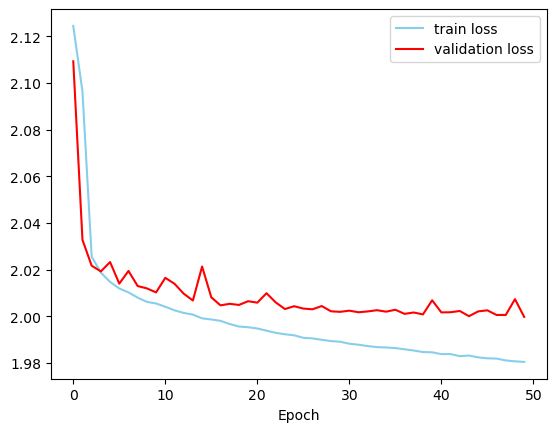

In [32]:
plt.plot(summary['train_loss'], color='skyblue', label='train loss')
plt.plot(summary['val_loss'], color='red', label='validation loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

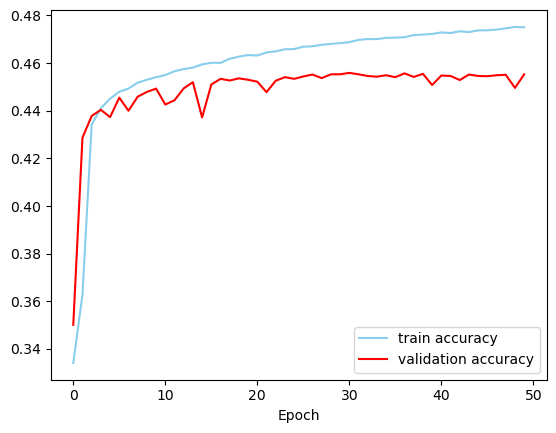

In [33]:
plt.plot(summary['train_score'], color='skyblue', label='train accuracy')
plt.plot(summary['val_score'], color='red', label='validation accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# References

- https://pytorch.org/tutorials/beginner/introyt/trainingyt.html?highlight=nn%20crossentropyloss
- https://www.kaggle.com/code/pankajj/fashion-mnist-with-pytorch-93-accuracy
- https://machinelearningspace.com/creating-custom-dataset-class-in-pytorch/#custom
- https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html
- https://discuss.pytorch.org/t/whats-the-difference-between-nn-relu-vs-f-relu/27599
- https://discuss.pytorch.org/t/training-doesnt-converge-when-running-on-m1-pro-gpu-mps-device/157918
- https://github.com/pytorch/pytorch/issues/109457